# Changelog
1. Added problem description to introduction
2. Changed all variable names for consistency
3. Merged some code of multiple cells to a single cell
4. Added 1.3 limitations dataset
5. Changed 2.2 cutoff values 0.5 -> 0.2, 0.5 -> 0.65
6. Changed 2.2 conclusion for new cutoff values
7. Moved 2.4 alternative method down to avoid confusion
8. Changed 2.4 conclusion

# SEN163A - Fundamentals of Data Analytics
# Assignment 3 - Large-scale Internet Data Analysis
### Ir. Jacopo De Stefani - [J.deStefani@tudelft.nl](mailto:J.deStefani@tudelft.nl)
### Joao Pizani Flor, M.Sc. - [J.p.pizaniflor@tudelft.nl](mailto:J.p.pizaniflor@tudelft.nl)

### 15-04-2022
## Group 2
- Emmanuel M Boateng - '5617642'
- Joost Oortwijn - '4593472'
- Philip Busscher - ''4611993''
- Floris Kool - ''4975243''


# Introduction & problem description
Tabularazor inc. is a large national newspaper covering many different topics. The company suffered an electrical malfunction causing a loss of archived data. Luckily they have a backup prepared of the articles published over the last couple of years. The backup from Tabularazor inc. contains the articles sorted by month and year, including the authors of the articles and the publishing day and time. In this assignment we will use this metadata to deduce some interesting facts about Tabularazors employees. We want to answer the following questions:<br>

a. Are there couples among the employees? <br>
b. Did any of the employees have childeren?<br>
c. How many holidays does an employee have?<br>

The problem with answering these questions is the fact that there is only metadata available. In other words, the available data does not not directly relate to these questions. But, based on our own interpretation of the available metadata, we can answer these questions. This interpretation will be eleborated on below in chapter 2.

We will start by describing how the data is retrieved from the backup using webscraping and describing the available data in chapter 1. After this, in chapter 2, the data is analyzed and conclusions will be drawn which are usefull for answering the above named questions.

# 1. Dataset description

The provided dataset contains an archief of a newpaper company with publications from to year 2012 till 2019. Per article, the publication date, publication time and the responsible author are included within the dataset. Based on these three attributes further analysis will be conducted.

The data can be found on a website (https://jdestefani.github.io/SEN163A-TabularRazorArchives/). That means that the data is stored on a webserver and a specific approach is required to obtain the data in the form of an HTML file. This process is called webscraping. To enable webscraping the python library Beautifulsoup is selected. This library contains the tools to work with HTML files like the provided data. Though, to obtain the data from the webserver, another library is necessary to generate HTTP requests. This library is called: requests

In [1]:
from bs4 import BeautifulSoup
import requests
from urllib.parse import urljoin
import pandas as pd
import time
import pickle
import datetime
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
#Run this to allign the tables correctly
%%html
<style>
table {float:left}
</style>

### Globally used variable names
complete_df - Dataframe with the author name, date and time for every article

employees_df - Dataframe with for each author and each day a field containing:

| Value in dataframe     | Meaning |
| ----------- | ----------- |
| 0      | not_employed       |
| 1   | Working        |
| 2   | Offday        |
| 3   | weekend_Working        |
| 4   | weekend_Offday        |

potential_couples - List of all possible pairs of two authors

couples_df - Dataframe with the following information for each author:
 - Number of days at least one of the couple wasn't employed
 - Number of days both people were working
 - Number of days only one of the couple was working
 - Number of days neither people were working during a weekend
 - Number of days neither people were working on a workday
 - ratio of days worked together over days that one person was working
 - ratio of days they were off together over days that only one person was off

## 1.1 Webscraping

In [ ]:
#READING MAIN PAGE
#Get file
source_link = "https://jdestefani.github.io/SEN163A-TabularRazorArchives/"
response = requests.get(source_link)

#Read main file
main_page = BeautifulSoup(response.text)

for year_link in main_page.find_all('a', href=True):
    #READING YEAR PAGE & SAVING PKL FILE FOR EACH YEAR
    
    #Get file name of pkl file
    year_filename = year_link.get('href')
    year_filename = year_filename.removeprefix('./')
    year_filename = year_filename.removesuffix('.html')
    year_filename = "data/" + year_filename + ".pkl"
    
    #Clear lists of data for each year
    data_tuple = []
    
    #Get file  
    year_link = urljoin(source_link, year_link.get('href')) 
    response = requests.get(year_link)
    
    #Read year file
    year_page = BeautifulSoup(response.text)
     
    for month_link in year_page.find_all('a', href=True):
        #Get file
        month_link = urljoin(year_link, month_link.get('href'))
        response = requests.get(month_link)
        
        #Read month file
        month_page = BeautifulSoup(response.text)
        i = 0
        
        start  = time.time()
        
        for article_link in month_page.find_all('a', href=True):        
            #Get file
            article_link = urljoin(month_link, article_link.get('href')) 
            response = requests.get(article_link)
        
            #Read article file
            article_page = BeautifulSoup(response.text)
                       
            for div_element in article_page.find_all('div'):
                if div_element.get('class') == ['author']:
                    article_author = div_element.get_text()
                if div_element.get('class') == ['date']:
                    article_date = div_element.get_text()
                if div_element.get('class') == ['time']:
                    article_time = div_element.get_text()

            #Add data
            data_tuple.append((article_author, article_date, article_time))
            i += 1 
            #if i >= 10:
            #    break
        
        #Print after each month
        dur = round(time.time() - start,2)
        print('Read: ' + month_link)
        print('Added: ' + str(i) + ' articles')
        print('Duration: ' + str(dur) + ' seconds')
        
        #break

    #Save file after each year
    print()
    print("---")
    print("Saving: " + year_filename)
    df = pd.DataFrame(data_tuple)
    df.to_pickle(year_filename)
    print("Saved: " + str(len(df[0])) + " articles")
    print("---")
    print()
    
    #break
    

## 1.2 Opening the dataset

In [3]:
#complete_df = pickle.load(open("2012_2019.pkl", "rb")) # use this as examiner
complete_df = pickle.load(open("data/2012_2019.pkl", "rb"))
complete_df = complete_df.reset_index()
complete_df = complete_df.drop(['index'], axis=1) 
complete_df.columns = ['Author','Date','Time']

## 1.3 Limitations dataset


Beforehand we must check if the dataset is clean and useable for the analysis. Therefore we check if the columns of interest contain the right value types and we check if there are NaN values in the dataset. 

In [4]:
# Check if there are missing errors in the dataset
complete_df.isnull().values.any()

False

In [5]:
# Check if only date times in column "date"
complete_df['Date'].dtypes

dtype('<M8[ns]')

In [6]:
# Check if only strings in column "author"
complete_df['Author'].dtypes

dtype('O')

Based on the check above we found no missing data in the dataset which could influence the analysis. All values had the expected datatype suitable for analyzing and also no NaN values are found in the dataset. 

The major limitations of this analysis is that we are using metadata of when an author publishes to make conclusions about when they are working. These limitations are described at the anwsers of each step

# 2 Analysis

The following analysis focuses on investigating how colleagues at Tubularazor are related to each other. By looking at the author names and publication dates of the articles, certain patterns can be observed. These patterns are able to clearify what kind of relations the employees have with respect to each other. We will look to find couples within Tubularazor authors, whether an author has had extended leave due to possible child birth and the average amount of holidays for employees of Tubularazor.

## 2.1 Tranform data

We will start by transforming the raw data into a dataset useful for our analysis questions. For our analysis we only need to know for each author on what day they have posted an article. This way we can deduce on what days people were working, which will be used in the questions.

After doing this we can add some extra information. An author might not be employed throughout the entire period that we're analyzing. We're using the date they first and last posted to deduce when someone might have started or stopped working for Trebularazor. We also noticed that there are significantly less articles posted in the weekend. We also want to include this information. The result is a dataset with a field for each author on each day that can have the following value:
- Not employed
- Working
- Day off
- Working on weekend
- weekend day off

In [11]:
# Create a dataframe with all the publication dates per author
merged_groupby = complete_df.groupby(['Author'])['Date'].unique().apply(list).reset_index()
merged_groupby = merged_groupby.set_index('Author')

# Split the list with publication dates to a column
split_df = pd.DataFrame(merged_groupby['Date'].tolist())
split_df = split_df.set_index(merged_groupby.index)
split_df = split_df.astype(str)

# Create range of dates from the beginning of 2012 till the end of 20190
start = datetime.strptime("2012-1-1", "%Y-%m-%d")
end = datetime.strptime("2019-12-31", "%Y-%m-%d")
date_generated = pd.date_range(start, end)

# Create new dataframe with only zero's 
zero_df = pd.DataFrame(np.zeros((len(split_df), len(date_generated)), np.uint8))
zero_df = zero_df.set_index(merged_groupby.index)
zero_df.columns = date_generated
zero_df.columns = zero_df.columns.strftime("%Y-%m-%d")

# Fill the new dataframe (with zero's) with ones in case an author has published on a specific date
list_index = list(split_df.index.values)

for i in list_index:
    for j in range(split_df.shape[1]):
        date = split_df.loc[i,j]
        if np.isnat(np.datetime64(date))==True:
            break
        else:
            zero_df.loc[i,date]=1

Creating a dataframe called employees_df with all employees and all days containing:


| Value in dataframe     | Meaning |
| ----------- | ----------- |
| 0      | not_employed       |
| 1   | Working        |
| 2   | Offday        |
| 3   | weekend_Working        |
| 4   | weekend_Offday        |



In [12]:
#Create dataframe
#Fill with not_employed until their first publication
#Fill with workdays and offdays based on publication
employees_data = []

for employee in zero_df.iterrows():
    days = []
    startedworking = False
    
    for day in employee[1]:
        if day == 1:
            startedworking = True
            days.append(1) #Working
        else:
            if startedworking:
                days.append(2) #Offday
            else:
                days.append(0) #not_employed
    
    employees_data.append(days)
                
employees_df = pd.DataFrame(employees_data, columns = date_generated.strftime("%Y-%m-%d"))
employees_df.index = zero_df.index


#Fill not employed based on last publication day
rowindex = 0

for employee in employees_df.iterrows():    
    
    #Run through the days reversed to find last publication day
    columnindex = len(employee[1])
    
    for day in reversed(employee[1]): 
        columnindex -= 1

        if day == 1:
            break
        else:        
            employees_df.iat[rowindex,columnindex] = 0 #not_employed    
            
    rowindex += 1
    
# Change weekend days to right lables
from datetime import datetime
for i in list(employees_df.index.values):
    for j in list(employees_df.columns):
        year = int(j[:4])
        month = int(j[5:7])
        day = int(j[-2:])
        date = datetime(year,month,day)
        if date.weekday() > 4:
            if employees_df.loc[i,j] == 1:
                employees_df.loc[i,j] = 3 #weekend_Working
            elif employees_df.loc[i,j] == 2:
                employees_df.loc[i,j] = 4 #weekend_Offday

## 2.2 Couple among employees (Question a)

The first test that will be conducted is whether there are couples among the authors and if they are still together.

In [13]:
#Create list of all potential couples
authors = set(employees_df.index)
potential_couples =  [couple for couple in combinations(authors,2)]  

Creating a dataframe with all couple of employees containing:
 - Number of days at least one of the couple wasn't employed
 - Number of days both people were working
 - Number of days only one of the couple was working
 - Number of days neither people were working during a weekend
 - Number of days neither people were working on a workday

In [14]:
#LOADING WILL TAKE SOME TIME (2-3 minutes)

not_employed = []
both_working = []
one_working = []
weekend = []
offdays = []
couples_data = []

start  = time.time()

#Check for all couples
for potential_couple in potential_couples:
    
    #Reset counters for each couple
    not_employed_count = 0
    both_working_count = 0
    one_working_count = 0
    weekend_count = 0
    offdays_count = 0
    templist = []
    
    #Select couple
    temp_df = employees_df.loc[[potential_couple[0],potential_couple[1]]]
    
    for column in temp_df:
        
        #Checking both employees for:
        #0 - not_employed
        #1 - Working
        #2 - Offday
        #3 - weekend_Working
        #4 - weekend_Offday
        
        #Add 1 to counter based on conditions mentioned in cell above
        if temp_df[column][0] == 0 or temp_df[column][1] == 0:
            not_employed_count += 1
        elif (temp_df[column][0] == 1 and temp_df[column][1] == 1) or (temp_df[column][0] == 3 and temp_df[column][1] == 3):
            both_working_count += 1
        elif (temp_df[column][0] == 1 or temp_df[column][1] == 1) or (temp_df[column][0] == 3 or temp_df[column][1] == 3):
            one_working_count += 1
        elif temp_df[column][0] == 4 and temp_df[column][1] == 4:
            weekend_count += 1
        else:
            offdays_count += 1
    
    #Add employee count data to tuple of lists
    templist.append(not_employed_count)
    templist.append(both_working_count)
    templist.append(one_working_count)
    templist.append(weekend_count)
    templist.append(offdays_count)           
    couples_data.append((templist))

#Create dataframe of all couples      
couples_df = pd.DataFrame(couples_data, columns = ['Not employed', 'Both working', 'One working', 'weekend', 'Off days'])
couples_df.index = potential_couples[:len(couples_data)]

dur = round(time.time() - start,2)
print("Loading took: " + str(dur) + " seconds")

Loading took: 136.15 seconds


To see if two people are a couple we assume they often work together and often take days off together. For all potential couples we will calculate two ratio's:
1. Days worked togeter over days that at least one person was working
2. Off days together over days that at least one person was not working

After some testing we noticed significant influences of days that people were unemployed and weekend days. If people were both not working for Trebulazor they had many "days off" together, by including the weekends we also had higher ratio's of people having many "days off" together. This is why we categorized these values in 2.1 and filtered for them in the cell below.

In [15]:
freetogether_ratio = []
worktogether_ratio = []

#Calculate ratio's for each couple by:
#Free days/ (Free days + One person working days)
#Both people working days/ (Both people working days + One person working days)

for potential_couple in couples_df.iterrows():
    
    #Added a divide by 0 check
    if potential_couple[1]['Off days'] + potential_couple[1]['One working'] != 0:
        freetogether_ratio.append(potential_couple[1]['Off days']/(potential_couple[1]['Off days'] + potential_couple[1]['One working']))
    else:
        freetogether_ratio.append(0)
    
    #Added a divide by 0 check
    if potential_couple[1]['Both working'] + potential_couple[1]['One working'] != 0:
        worktogether_ratio.append(potential_couple[1]['Both working']/(potential_couple[1]['Both working'] + potential_couple[1]['One working']))
    else:
        worktogether_ratio.append(0)

couples_df['free_ratio'] = freetogether_ratio
couples_df['work_ratio'] = worktogether_ratio

#couples_df


[Text(0.5, 0, 'Ratio'),
 Text(0, 0.5, '=Frequency'),
 Text(0.5, 1.0, 'Work days ratio')]

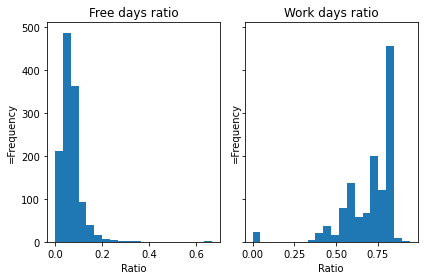

In [16]:
#Plot the distribution of ratio's to help find couples
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

axs[0].hist(couples_df['free_ratio'], bins=20)
axs[1].hist(couples_df['work_ratio'], bins=20)

axs[0].set(xlabel='Ratio', ylabel='=Frequency',
       title='Free days ratio')
axs[1].set(xlabel='Ratio', ylabel='=Frequency',
       title='Work days ratio')


In [17]:
couples = []

#Cutoff values:
free_ratio_cutoff = 0.2
work_ratio_cutoff = 0.65

#Add couples with ratio's higher than the cutoff values
for potential_couple in couples_df.iterrows():
    if potential_couple[1]['free_ratio'] >= free_ratio_cutoff and potential_couple[1]['work_ratio'] >= work_ratio_cutoff:
        couples.append(potential_couple[0])

print(str(len(couples)) + " couples found")

selected_couples_df = couples_df.loc[couples]

selected_couples_df

3 couples found


,Not employed,Both working,One working,weekend,Off days,free_ratio,work_ratio
"(Augusta Beltrami, Grover Gibbons)",1827,695,44,268,88,0.666667,0.940460
"(Corrine Gallop, Randall Feather)",1552,611,281,355,123,0.304455,0.684978
"(Julieta Knapp, Vonk Billips)",1,1849,211,739,122,0.366366,0.897573


### Conclusion
To check which pairs of authors might be a couple we use the ratio's described earlier. Using the cutoff values (in the cell above) we can set different thresholds for what a couple is and how often they would need to work together or take days off together. Before removing the weekend and not employed days we noticed many potential couples and changing the cutoff values changed the outcomes. 

After removing the weekend and not employed days however we only noticed one clear outlier: Grover Gibbons & Augusta Beltrami. Out of the 739 days they were working 695 days were worked together (94%) and out of 132 holidays 88 were at the same time (67%). When lowering the cutoff values we identified two other couples: Vonk Billips & Julieta Knapp and Randall Feather and Corrine Gallop. These couples did only take 37% and 30% percent of their off days together, so it is hard to say with certainty if these are actual couples. 

Lowering the cutoff values further resulted in many more couples being identified, with some authors being in multiple couples. Therefor we think that 20% free days ratio and 65% work days ratio are correct cutoff values.

## 2.3 Children (Question b)
*Did any of the employees have a child? If so, who?*

To deduce whether someone had a child we can use the number of days that people were not publishing for Tabularazor. Though we can only speculate why a person has a long period between publishing we will asume that if a person is away for longer than 80 days she is away for pregnancy leave.

In [18]:
#find max time employees pauses for all employees

employees = complete_df['Author'].unique().tolist()
d = []
for names in employees:
    df_f =  complete_df.loc[complete_df['Author']==names]
    diff = df_f['Date'].diff().max()
    #print(diff)
    d.append([names,diff])
    #print(names, df_f['Date'].diff().max())

#create a dataframe from the list
overview = pd.DataFrame(d,columns=['Author', 'Max_Absence'])
#convert to int
overview['Max_Absence'] = overview['Max_Absence'].dt.days
#sort the values
overview = overview.sort_values(by='Max_Absence', ascending=False)

#show the head.
overview.head()



,Author,Max_Absence
47,Corrine Gallop,136
20,Marthe Hale,128
17,Julieta Knapp,25
37,Augusta Beltrami,25
38,Grover Gibbons,25


### Conclusion
Looking at the maximum time between publishing dates their are two clear outliers: Corrine Gallop and Marthe Hale. Both have around 130 days leave, with the 3rd highest time between posting being only 25 days. As mentioned earlier there could be many causes for this time between posting, but we will asume Corrine Gallop and Marthe Hale were on pregnancy leave.

## 2.4 Holidays (Question c)
*If you would be looking to work for Tabularazor Inc., how many holidays can you expect to get per
year?*

To answer how many holidays a person can expect when working at Tabularazor we will look at the amount of days an author was not publishing, ignoring the weekend days and days not employed. To do this we checked for each employee the ratio of days off over the days the employee is "supposed" to work. For each extra day worked in the weekend we substracted a holiday as the employee then worked more than the standard work days.

After calculating the ratio's we multiply this by the standard number of yearly working days to find the average amount of yearly holidays for each employee. To calculate the total average yearly holidays we calculated the average of all the employees average yearly holidays.

This method was useful for finding the average yearly holidays per employee. However to calculate the average of all employees it's more accurate to look at the total working days of all employees and days off of all employees. This way employees that worked at Tabularazor longer have more influence over the average than a person only working there temporary.

In [19]:
off_days = 0
work_days = 0

for employee in employees_df.iterrows():    
        
    for day in employee[1]: 
        
        #Checking employee days for:
        #0 - not_employed
        #1 - Working
        #2 - Offday
        #3 - weekend_Working
        #4 - weekend_Offday
        
        #Count the working days when this employee was employed
        if day != 0 and day != 4:
            work_days += 1
        #Count days off
        if day == 2:
            off_days += 1
        #Remove extra days worked from off days
        elif day == 3:
            off_days -= 1
            
ratio = off_days/work_days

yearly_work_days = (5 *365/7)

average_holidays = round(yearly_work_days * ratio)

print("Average yearly holidays: " + str(average_holidays))

Average yearly holidays: 29


### Conclusion

The average number of holidays an employee can expect is 29. 

The number does seem to differ a lot over different employees. Roughly speaking people that worked there less (likely temporary writers) get more days off. Though, there are also other factors influencing these extra days off, like extra leave due to pregnancy. With the code below we show the distribution of holidays across all employees. We also calculate the average number of holidays taken over all employees (instead of all days worked like done above). This is less accurate, but does show the difference between employees.

In [20]:
off_days = []
work_days = []
ratios = []
yearly_holidays = []

#Amount of non weekend days per year
yearly_work_days = (5 *365/7)

for employee in employees_df.iterrows():    
    
    off_days_count = 0
    work_days_count = 0
    
    for day in employee[1]: 
        
        #Checking employee days for:
        #0 - Not_employed
        #1 - Working
        #2 - Offday
        #3 - Weekend_Working
        #4 - Weekend_Offday
        
        #Count the working days when this employee was employed
        if day != 0 and day != 4:
            work_days_count += 1
        #Count days off
        if day == 2:
            off_days_count += 1
        #Remove extra days worked from off days
        elif day == 3:
            off_days_count-= 1
    
    off_days.append(off_days_count)
    work_days.append(work_days_count)
    
    ratio = off_days_count/work_days_count
    ratios.append(ratio)
    
    yearly_holidays.append(round(ratio * yearly_work_days))
 
employees_df["Off days"] = off_days
employees_df["Work days"] = work_days
employees_df["Off day ratio"] = ratios
employees_df["Yearly holidays"] = yearly_holidays

average_holidays_employee = round(employees_df["Yearly holidays"].mean())

print("Average yearly holidays over employees: " + str(average_holidays_employee))
print("Average yearly holidays over days worked: " + str(average_holidays))

display_df = employees_df[["Off days", "Work days", "Off day ratio", "Yearly holidays"]]

display_df

Average yearly holidays over employees: 31
Average yearly holidays over days worked: 29


,Off days,Work days,Off day ratio,Yearly holidays
Author,,,,
Adriene Wilde,255,812,0.314039,82
Andreas Jost,110,2140,0.051402,13
Angela Compos,152,1001,0.151848,40
Anisha Mathes,332,2135,0.155504,41
Annie Lapham,506,2132,0.237336,62
Augusta Beltrami,63,808,0.077970,20
Aurea Durrance,336,2138,0.157156,41
Bebe Riva,114,2145,0.053147,14
Bridgette Marko,117,2139,0.054698,14
